# Titanic Dataset with Fast.ai library

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./fastai2018') # Add fastai module to path
from fastai.structured import *
from fastai.column_data import *
from torch.nn import functional as F

D_PATH = 'data/titanic/'

## Create datasets

In [129]:
table_names = ['train', 'test'] # Names of the csv files I will use

In [130]:
#Load the tables
tables = [pd.read_csv(f'{D_PATH}{fname}.csv', low_memory=False) for fname in table_names ]

In [131]:
# Let's see what's in each of the tables
for t in tables: display(t.head())

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

## Preprocessing

In [145]:
train, test = tables

In [146]:
# How long are the train and test sets?
len(train), len(test)

(891, 418)

Let's get rid of the name and ticket columns

In [147]:
train = train.drop(['Name', 'Ticket'], axis=1)
test = test.drop(['Name', 'Ticket'], axis=1)
display(train.head())

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin  \
0            1         0       3    male  22.0      1      0   7.2500   NaN   
1            2         1       1  female  38.0      1      0  71.2833   C85   
2            3         1       3  female  26.0      0      0   7.9250   NaN   
3            4         1       1  female  35.0      1      0  53.1000  C123   
4            5         0       3    male  35.0      0      0   8.0500   NaN   

  Embarked  
0        S  
1        C  
2        S  
3        S  
4        S

In [148]:
# Change cabin numbers to only show the letter and replace unkowns with U
train['Cabin'] = train['Cabin'].str[0]
train['Cabin'] = train.Cabin.fillna('U')
train.head()

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin  \
0            1         0       3    male  22.0      1      0   7.2500     U   
1            2         1       1  female  38.0      1      0  71.2833     C   
2            3         1       3  female  26.0      0      0   7.9250     U   
3            4         1       1  female  35.0      1      0  53.1000     C   
4            5         0       3    male  35.0      0      0   8.0500     U   

  Embarked  
0        S  
1        C  
2        S  
3        S  
4        S

## Create Features

In [149]:
# We need to seperate categorical and coninuous variables
cat_vars = ['Pclass', 'Sex', 'Age', 'Cabin', 'Embarked']


contin_vars = ['SibSp', 'Parch', 'Fare']

n = len(train); n

891

In [150]:
dep = 'Survived' # Dependent variable
train = train[cat_vars+contin_vars+[dep, 'PassengerId']].copy()
# train = train[cat_vars+[dep, 'PassengerId']].copy()

In [151]:
test[dep] = 0
test[dep] = test[dep].astype('category').cat.as_ordered()
test[dep] = test[dep].cat.codes
test = test[cat_vars+contin_vars+[dep, 'PassengerId']].copy()


In [155]:
for v in cat_vars: 
    train[v] = train[v].astype('category').cat.as_ordered()
#     test[v] = test[v].astype('category').cat_as_ordered()
# train['Survived'] = train['Survived'].astype('category').cat.as_ordered()

In [156]:
apply_cats(test, train)

In [157]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')
#train['Survived'] = train['Survived'].astype('float32')

In [158]:
# To run on full dataset use:
samp_size = n
train = train.set_index("PassengerId")

In [159]:
train[dep] = train[dep].astype('float64')
df, y, nas, mapper = proc_df(train, 'Survived', do_scale=True)
# yl = np.log(y)


In [181]:
test = test.set_index("PassengerId")
test['Fare'] = test.Fare.fillna(test.Fare.mean())

In [182]:
df_test, _, nas, mapper = proc_df(test, 'Survived', do_scale=True,
                                 mapper=mapper, na_dict=nas)

In [187]:
df.head(2); df_test.head(10)
# df_test.drop(['Fare_na'])

Pclass  Sex  Age  Cabin  Embarked     SibSp     Parch      Fare  \
PassengerId                                                                    
892               3    2   47      0         2 -0.474545 -0.473674 -0.490783   
893               3    1   63      0         3  0.432793 -0.473674 -0.507479   
894               2    2   79      0         2 -0.474545 -0.473674 -0.453367   
895               3    2   36      0         3 -0.474545 -0.473674 -0.474005   
896               3    1   29      0         3  0.432793  0.767630 -0.401017   
897               3    2   19      0         3 -0.474545 -0.473674 -0.462679   
898               3    1   40      0         2 -0.474545 -0.473674 -0.494810   
899               2    2   35      0         3  0.432793  0.767630 -0.064516   
900               3    1   24      0         1 -0.474545 -0.473674 -0.502864   
901               3    2   28      0         3  1.340132 -0.473674 -0.162169   

             Fare_na  
PassengerId           
892            False  
893            False  
894            False  
895            False  
896            False  
897            False  
898            False  
899            False  
900            False  
901            False

In [171]:
train = df

In [184]:
# Let's use the last 25% of our data as the validation set
train_ratio = .75
train_size = int(samp_size*train_ratio); train_size
val_idx = list(range(train_size, len(train)))

In [173]:
# trn_df, trn_y = train[cat_vars+contin_vars].iloc[:train_size], train.Survived[:train_size].astype('int')
# val_df, val_y = train[cat_vars+contin_vars].iloc[train_size:], train.Survived[train_size:].astype('int')
trn_df, trn_y = train[cat_vars+contin_vars].iloc[:train_size], y[:train_size] #train.Survived[:train_size].astype('int')
val_df, val_y = train[cat_vars+contin_vars].iloc[train_size:], y[train_size:] #train.Survived[train_size:].astype('int')

AxisError: axis 1 is out of bounds for array of dimension 1

## Let's finally do some Machine Learning


#### Fast.ai Mods: https://github.com/KeremTurgutlu/deeplearning/blob/master/avazu/FAST.AI%20Classification%20-%20Kaggle%20Avazu%20CTR.ipynb

In [ ]:
# FAST.AI Modifications
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x

In [ ]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y # THIS LINE IS CHANGED FROM y[:, None]
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)

In [ ]:
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

### Back to the Learning

In [46]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = targ
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

NameError: name 'yl' is not defined

In [174]:
val_y.astype('int')

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [175]:
# Lets create a ModelData object from the out dataframe

md = ColumnarModelData.from_data_frames('/tmp', trn_df, val_df, trn_y, 
                val_y, cat_vars, 16, test_df=test[cat_vars])

ValueError: cannot convert float NaN to integer

In [103]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars ]; cat_sz

[('Pclass', 4), ('Sex', 3), ('Age', 89), ('Cabin', 10), ('Embarked', 4)]

In [104]:
# Size of Embeddings
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]; emb_szs

[(4, 2), (3, 2), (89, 45), (10, 5), (4, 2)]

In [105]:
bm = BasicModel(model, 'binary_classifier')
model = MixedInputModel(emb_szs, n_cont=0, emb_drop=0, out_sz=2, szs=[250], drops=[.01]).cuda()

In [106]:
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss


learn = StructuredLearner(md, bm)

In [107]:
learn.crit = F.cross_entropy
learn.crit

<function torch.nn.functional.cross_entropy>

In [117]:
learn.lr_find()

A Jupyter Widget

  0%|          | 0/42 [00:00<?, ?it/s]


RuntimeError: Expected object of type torch.cuda.LongTensor but found type torch.cuda.FloatTensor for argument #2 'target'

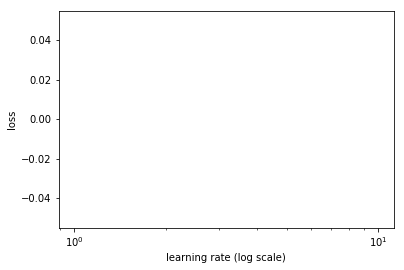

In [164]:
m.sched.plot(100)

### Sample

In [248]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                  0.04, 1, [1000, 500], [.001, .01], y_range=y_range)
lr=1e-3

In [249]:
#m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

In [297]:
m.fit(lr, 3, cycle_len=1)

A Jupyter Widget

  0%|          | 0/42 [00:00<?, ?it/s, loss=inf
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
 43%|████▎     | 18/42 [00:00<00:00, 174.81it/s, loss=nan
 43%|████▎     | 18/42 [00:00<00:00, 166.47it/s, loss=nan
 43%|████▎     | 18/

./fastai2018/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


 86%|████████▌ | 36/42 [00:00<00:00, 164.23it/s, loss=nan
 86%|████████▌ | 36/42 [00:00<00:00, 159.36it/s, loss=nan
 86%|████████▌ | 36/42 [00:00<00:00, 155.08it/s, loss=nan
 86%|████████▌ | 36/42 [00:00<00:00, 150.62it/s, loss=nan
epoch      trn_loss   val_loss                                                                        
    0      nan        nan       
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|   

[nan]

In [101]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

A Jupyter Widget

  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
 48%|████▊     | 20/42 [00:00<00:00, 192

./fastai2018/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


 95%|█████████▌| 40/42 [00:00<00:00, 187.40it/s, loss=nan
 95%|█████████▌| 40/42 [00:00<00:00, 182.00it/s, loss=nan
epoch      trn_loss   val_loss   exp_rmspe                                                            
    0      nan        nan        nan       
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 0/42 [00:00<?, ?it/s, loss=nan
  0%|          | 

[nan, nan]

In [108]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

A Jupyter Widget

  0%|          | 0/879 [00:00<?, ?it/s, loss=1.00000e-03 *
  8.8602
  0%|          | 0/879 [00:00<?, ?it/s, loss=1.00000e-03 *
  8.5327
  0%|          | 2/879 [00:00<00:44, 19.67it/s, loss=1.00000e-03 *
  8.5327
  0%|          | 2/879 [00:00<00:56, 15.47it/s, loss=1.00000e-03 *
  8.1507
  0%|          | 2/879 [00:00<01:07, 13.07it/s, loss=1.00000e-03 *
  7.9070
  0%|          | 2/879 [00:00<01:17, 11.33it/s, loss=1.00000e-03 *
  8.1650
  0%|          | 2/879 [00:00<01:28,  9.92it/s, loss=1.00000e-03 *
  7.9203
  1%|          | 6/879 [00:00<00:29, 29.64it/s, loss=1.00000e-03 *
  7.9203
  1%|          | 6/879 [00:00<00:32, 26.59it/s, loss=1.00000e-03 *
  7.8343
  1%|          | 6/879 [00:00<00:35, 24.34it/s, loss=1.00000e-03 *
  7.9979
  1%|          | 6/879 [00:00<00:39, 21.83it/s, loss=1.00000e-03 *
  7.9878
[torch.cuda.FloatTensor of size () (GPU 0)]]

./fastai2018/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


  1%|          | 6/879 [00:00<00:43, 20.17it/s, loss=1.00000e-03 *
  7.9416
  1%|          | 6/879 [00:00<00:46, 18.61it/s, loss=1.00000e-03 *
  7.9449
  1%|▏         | 11/879 [00:00<00:25, 34.05it/s, loss=1.00000e-03 *
  7.9449
  1%|▏         | 11/879 [00:00<00:27, 31.80it/s, loss=1.00000e-03 *
  8.0169
  1%|▏         | 11/879 [00:00<00:29, 29.60it/s, loss=1.00000e-03 *
  8.1809
  1%|▏         | 11/879 [00:00<00:31, 27.95it/s, loss=1.00000e-03 *
  8.3199
  1%|▏         | 11/879 [00:00<00:32, 26.46it/s, loss=1.00000e-03 *
  8.2975
  1%|▏         | 11/879 [00:00<00:34, 24.94it/s, loss=1.00000e-03 *
  8.2690
  2%|▏         | 16/879 [00:00<00:23, 36.22it/s, loss=1.00000e-03 *
  8.2690
  2%|▏         | 16/879 [00:00<00:24, 34.66it/s, loss=1.00000e-03 *
  8.2014
  2%|▏         | 16/879 [00:00<00:26, 32.57it/s, loss=1.00000e-03 *
  8.2524
  2%|▏         | 16/879 [00:00<00:27, 31.29it/s, loss=1.00000e-03 *
  8.2130
  2%|▏         | 16/879 [00:00<00:28, 29.97it/s, loss=1.00000e-03 *
  8.0907
 

 22%|██▏       | 197/879 [00:02<00:08, 80.73it/s, loss=1.00000e-03 *
  9.7337
 22%|██▏       | 197/879 [00:02<00:08, 80.48it/s, loss=1.00000e-03 *
  9.7346
 22%|██▏       | 197/879 [00:02<00:08, 80.20it/s, loss=1.00000e-03 *
  9.7482
 22%|██▏       | 197/879 [00:02<00:08, 79.94it/s, loss=1.00000e-03 *
  9.7883
 22%|██▏       | 197/879 [00:02<00:08, 79.68it/s, loss=1.00000e-03 *
  9.7823
 22%|██▏       | 197/879 [00:02<00:08, 79.43it/s, loss=1.00000e-03 *
  9.8632
 22%|██▏       | 197/879 [00:02<00:08, 79.17it/s, loss=1.00000e-03 *
  9.9364
 22%|██▏       | 197/879 [00:02<00:08, 78.91it/s, loss=1.00000e-03 *
  9.9781
 22%|██▏       | 197/879 [00:02<00:08, 78.64it/s, loss=1.00000e-02 *
  1.0028
 22%|██▏       | 197/879 [00:02<00:08, 78.39it/s, loss=1.00000e-02 *
  1.0090
 24%|██▍       | 210/879 [00:02<00:08, 83.54it/s, loss=1.00000e-02 *
  1.0090
 24%|██▍       | 210/879 [00:02<00:08, 83.28it/s, loss=1.00000e-02 *
  1.0384
 24%|██▍       | 210/879 [00:02<00:08, 83.03it/s, loss=1.00000e-

 45%|████▍     | 395/879 [00:04<00:05, 95.07it/s, loss=1.00000e-02 *
  1.3658
 45%|████▍     | 395/879 [00:04<00:05, 94.88it/s, loss=1.00000e-02 *
  1.3625
 45%|████▍     | 395/879 [00:04<00:05, 94.67it/s, loss=1.00000e-02 *
  1.3581
 45%|████▍     | 395/879 [00:04<00:05, 94.49it/s, loss=1.00000e-02 *
  1.3569
 45%|████▍     | 395/879 [00:04<00:05, 94.31it/s, loss=1.00000e-02 *
  1.3557
 45%|████▍     | 395/879 [00:04<00:05, 94.12it/s, loss=1.00000e-02 *
  1.3578
 45%|████▍     | 395/879 [00:04<00:05, 93.95it/s, loss=1.00000e-02 *
  1.3547
 45%|████▍     | 395/879 [00:04<00:05, 93.76it/s, loss=1.00000e-02 *
  1.3526
 45%|████▍     | 395/879 [00:04<00:05, 93.59it/s, loss=1.00000e-02 *
  1.3497
 45%|████▍     | 395/879 [00:04<00:05, 93.40it/s, loss=1.00000e-02 *
  1.3469
 45%|████▍     | 395/879 [00:04<00:05, 93.23it/s, loss=1.00000e-02 *
  1.3382
 45%|████▍     | 395/879 [00:04<00:05, 93.05it/s, loss=1.00000e-02 *
  1.3462
 45%|████▍     | 395/879 [00:04<00:05, 92.89it/s, loss=1.00000e-

 66%|██████▋   | 583/879 [00:05<00:02, 100.78it/s, loss=1.00000e-02 *
  1.3425
 66%|██████▋   | 583/879 [00:05<00:02, 100.64it/s, loss=1.00000e-02 *
  1.3479
 66%|██████▋   | 583/879 [00:05<00:02, 100.49it/s, loss=1.00000e-02 *
  1.3409
 66%|██████▋   | 583/879 [00:05<00:02, 100.35it/s, loss=1.00000e-02 *
  1.3404
 66%|██████▋   | 583/879 [00:05<00:02, 100.21it/s, loss=1.00000e-02 *
  1.3374
 66%|██████▋   | 583/879 [00:05<00:02, 100.06it/s, loss=1.00000e-02 *
  1.3415
 66%|██████▋   | 583/879 [00:05<00:02, 99.93it/s, loss=1.00000e-02 *
  1.3426
 68%|██████▊   | 596/879 [00:05<00:02, 102.14it/s, loss=1.00000e-02 *
  1.3426
 68%|██████▊   | 596/879 [00:05<00:02, 102.00it/s, loss=1.00000e-02 *
  1.3553
 68%|██████▊   | 596/879 [00:05<00:02, 101.86it/s, loss=1.00000e-02 *
  1.3525
 68%|██████▊   | 596/879 [00:05<00:02, 101.69it/s, loss=1.00000e-02 *
  1.3508
 68%|██████▊   | 596/879 [00:05<00:02, 101.56it/s, loss=1.00000e-02 *
  1.3490
 68%|██████▊   | 596/879 [00:05<00:02, 101.41it/s, lo

 77%|███████▋  | 675/879 [00:06<00:01, 102.67it/s, loss=1.00000e-02 *
  1.3086
 77%|███████▋  | 675/879 [00:06<00:01, 102.56it/s, loss=1.00000e-02 *
  1.3077
 78%|███████▊  | 688/879 [00:06<00:01, 104.53it/s, loss=1.00000e-02 *
  1.3077
 78%|███████▊  | 688/879 [00:06<00:01, 104.39it/s, loss=1.00000e-02 *
  1.3057
 78%|███████▊  | 688/879 [00:06<00:01, 104.27it/s, loss=1.00000e-02 *
  1.3059
 78%|███████▊  | 688/879 [00:06<00:01, 104.12it/s, loss=1.00000e-02 *
  1.3126
 78%|███████▊  | 688/879 [00:06<00:01, 104.01it/s, loss=1.00000e-02 *
  1.3133
 78%|███████▊  | 688/879 [00:06<00:01, 103.88it/s, loss=1.00000e-02 *
  1.3139
 78%|███████▊  | 688/879 [00:06<00:01, 103.76it/s, loss=1.00000e-02 *
  1.3099
 78%|███████▊  | 688/879 [00:06<00:01, 103.64it/s, loss=1.00000e-02 *
  1.3114
 78%|███████▊  | 688/879 [00:06<00:01, 103.52it/s, loss=1.00000e-02 *
  1.3113
 78%|███████▊  | 688/879 [00:06<00:01, 103.39it/s, loss=1.00000e-02 *
  1.3070
 78%|███████▊  | 688/879 [00:06<00:01, 103.27it/s, l

 89%|████████▊ | 779/879 [00:07<00:00, 105.70it/s, loss=1.00000e-02 *
  1.2899
 89%|████████▊ | 779/879 [00:07<00:00, 105.58it/s, loss=1.00000e-02 *
  1.2891
 89%|████████▊ | 779/879 [00:07<00:00, 105.48it/s, loss=1.00000e-02 *
  1.2841
 89%|████████▊ | 779/879 [00:07<00:00, 105.36it/s, loss=1.00000e-02 *
  1.2796
 89%|████████▊ | 779/879 [00:07<00:00, 105.25it/s, loss=1.00000e-02 *
  1.2916
 89%|████████▊ | 779/879 [00:07<00:00, 105.11it/s, loss=1.00000e-02 *
  1.3096
 89%|████████▊ | 779/879 [00:07<00:00, 105.01it/s, loss=1.00000e-02 *
  1.3096
 89%|████████▊ | 779/879 [00:07<00:00, 104.89it/s, loss=1.00000e-02 *
  1.3087
 89%|████████▊ | 779/879 [00:07<00:00, 104.78it/s, loss=1.00000e-02 *
  1.3119
 89%|████████▊ | 779/879 [00:07<00:00, 104.65it/s, loss=1.00000e-02 *
  1.3332
 90%|█████████ | 792/879 [00:07<00:00, 106.39it/s, loss=1.00000e-02 *
  1.3332
 90%|█████████ | 792/879 [00:07<00:00, 106.29it/s, loss=1.00000e-02 *
  1.3277
 90%|█████████ | 792/879 [00:07<00:00, 106.16it/s, l

epoch      trn_loss   val_loss   exp_rmspe                                                                                 
    0      0.012691   0.013326   0.118924  
  0%|          | 0/879 [00:00<?, ?it/s, loss=1.00000e-02 *
  1.2580
  0%|          | 0/879 [00:00<?, ?it/s, loss=1.00000e-02 *
  1.2505
  0%|          | 0/879 [00:00<?, ?it/s, loss=1.00000e-02 *
  1.2402
  0%|          | 3/879 [00:00<00:34, 25.49it/s, loss=1.00000e-02 *
  1.2402
  0%|          | 3/879 [00:00<00:40, 21.56it/s, loss=1.00000e-02 *
  1.2359
  0%|          | 3/879 [00:00<00:46, 18.66it/s, loss=1.00000e-02 *
  1.2323
  0%|          | 3/879 [00:00<00:53, 16.46it/s, loss=1.00000e-02 *
  1.2281
  0%|          | 3/879 [00:00<00:59, 14.79it/s, loss=1.00000e-02 *
  1.2322
  0%|          | 3/879 [00:00<01:05, 13.31it/s, loss=1.00000e-02 *
  1.2397
  1%|          | 8/879 [00:00<00:24, 35.39it/s, loss=1.00000e-02 *
  1.2397
  1%|          | 8/879 [00:00<00:27, 32.02it/s, loss=1.00000e-02 *
  1.2332
  1%|          | 8/8

 10%|▉         | 87/879 [00:01<00:12, 63.02it/s, loss=1.00000e-02 *
  1.0878
 10%|▉         | 87/879 [00:01<00:12, 62.67it/s, loss=1.00000e-02 *
  1.0901
 10%|▉         | 87/879 [00:01<00:12, 62.31it/s, loss=1.00000e-02 *
  1.0869
 10%|▉         | 87/879 [00:01<00:12, 61.98it/s, loss=1.00000e-02 *
  1.0837
 10%|▉         | 87/879 [00:01<00:12, 61.62it/s, loss=1.00000e-02 *
  1.0923
 10%|▉         | 87/879 [00:01<00:12, 61.29it/s, loss=1.00000e-02 *
  1.0884
 10%|▉         | 87/879 [00:01<00:12, 60.98it/s, loss=1.00000e-02 *
  1.0855
 11%|█▏        | 100/879 [00:01<00:11, 70.06it/s, loss=1.00000e-02 *
  1.0855
 11%|█▏        | 100/879 [00:01<00:11, 69.70it/s, loss=1.00000e-02 *
  1.0860
 11%|█▏        | 100/879 [00:01<00:11, 69.34it/s, loss=1.00000e-02 *
  1.0864
 11%|█▏        | 100/879 [00:01<00:11, 68.94it/s, loss=1.00000e-02 *
  1.0818
 11%|█▏        | 100/879 [00:01<00:11, 68.61it/s, loss=1.00000e-02 *
  1.0804
 11%|█▏        | 100/879 [00:01<00:11, 68.21it/s, loss=1.00000e-02 *
  

 32%|███▏      | 279/879 [00:02<00:06, 93.81it/s, loss=1.00000e-02 *
  1.1290
 32%|███▏      | 279/879 [00:02<00:06, 93.57it/s, loss=1.00000e-02 *
  1.1207
 32%|███▏      | 279/879 [00:02<00:06, 93.31it/s, loss=1.00000e-02 *
  1.1147
 32%|███▏      | 279/879 [00:02<00:06, 93.06it/s, loss=1.00000e-02 *
  1.1188
 33%|███▎      | 292/879 [00:02<00:06, 97.38it/s, loss=1.00000e-02 *
  1.1188
 33%|███▎      | 292/879 [00:03<00:06, 97.14it/s, loss=1.00000e-02 *
  1.1150
 33%|███▎      | 292/879 [00:03<00:06, 96.87it/s, loss=1.00000e-02 *
  1.1290
 33%|███▎      | 292/879 [00:03<00:06, 96.60it/s, loss=1.00000e-02 *
  1.1261
 33%|███▎      | 292/879 [00:03<00:06, 96.34it/s, loss=1.00000e-02 *
  1.1211
 33%|███▎      | 292/879 [00:03<00:06, 96.05it/s, loss=1.00000e-02 *
  1.1199
 33%|███▎      | 292/879 [00:03<00:06, 95.80it/s, loss=1.00000e-02 *
  1.1151
 33%|███▎      | 292/879 [00:03<00:06, 95.54it/s, loss=1.00000e-02 *
  1.1128
 33%|███▎      | 292/879 [00:03<00:06, 95.28it/s, loss=1.00000e-

 44%|████▎     | 383/879 [00:03<00:04, 101.74it/s, loss=1.00000e-02 *
  1.1180
 44%|████▎     | 383/879 [00:03<00:04, 101.53it/s, loss=1.00000e-02 *
  1.1217
 44%|████▎     | 383/879 [00:03<00:04, 101.32it/s, loss=1.00000e-02 *
  1.1283
 44%|████▎     | 383/879 [00:03<00:04, 101.11it/s, loss=1.00000e-02 *
  1.1213
 44%|████▎     | 383/879 [00:03<00:04, 100.87it/s, loss=1.00000e-02 *
  1.1200
 44%|████▎     | 383/879 [00:03<00:04, 100.65it/s, loss=1.00000e-02 *
  1.1211
 44%|████▎     | 383/879 [00:03<00:04, 100.43it/s, loss=1.00000e-02 *
  1.1177
 44%|████▎     | 383/879 [00:03<00:04, 100.24it/s, loss=1.00000e-02 *
  1.1189
 44%|████▎     | 383/879 [00:03<00:04, 100.01it/s, loss=1.00000e-02 *
  1.1130
 44%|████▎     | 383/879 [00:03<00:04, 99.82it/s, loss=1.00000e-02 *
  1.1160
 44%|████▎     | 383/879 [00:03<00:04, 99.59it/s, loss=1.00000e-02 *
  1.1140
 45%|████▌     | 396/879 [00:03<00:04, 102.96it/s, loss=1.00000e-02 *
  1.1140
 45%|████▌     | 396/879 [00:03<00:04, 102.76it/s, los

 54%|█████▍    | 474/879 [00:04<00:03, 104.15it/s, loss=1.00000e-02 *
  1.1214
 54%|█████▍    | 474/879 [00:04<00:03, 103.96it/s, loss=1.00000e-02 *
  1.1199
 54%|█████▍    | 474/879 [00:04<00:03, 103.78it/s, loss=1.00000e-02 *
  1.1279
 54%|█████▍    | 474/879 [00:04<00:03, 103.59it/s, loss=1.00000e-02 *
  1.1245
 54%|█████▍    | 474/879 [00:04<00:03, 103.41it/s, loss=1.00000e-02 *
  1.1217
 55%|█████▌    | 487/879 [00:04<00:03, 106.23it/s, loss=1.00000e-02 *
  1.1217
 55%|█████▌    | 487/879 [00:04<00:03, 106.06it/s, loss=1.00000e-02 *
  1.1241
 55%|█████▌    | 487/879 [00:04<00:03, 105.86it/s, loss=1.00000e-02 *
  1.1338
 55%|█████▌    | 487/879 [00:04<00:03, 105.68it/s, loss=1.00000e-02 *
  1.1348
 55%|█████▌    | 487/879 [00:04<00:03, 105.51it/s, loss=1.00000e-02 *
  1.1327
 55%|█████▌    | 487/879 [00:04<00:03, 105.31it/s, loss=1.00000e-02 *
  1.1294
 55%|█████▌    | 487/879 [00:04<00:03, 105.13it/s, loss=1.00000e-02 *
  1.1281
 55%|█████▌    | 487/879 [00:04<00:03, 104.93it/s, l

 66%|██████▌   | 578/879 [00:05<00:02, 108.22it/s, loss=1.00000e-02 *
  1.0738
 66%|██████▌   | 578/879 [00:05<00:02, 108.05it/s, loss=1.00000e-02 *
  1.0772
 66%|██████▌   | 578/879 [00:05<00:02, 107.89it/s, loss=1.00000e-02 *
  1.0761
 66%|██████▌   | 578/879 [00:05<00:02, 107.74it/s, loss=1.00000e-02 *
  1.0752
 66%|██████▌   | 578/879 [00:05<00:02, 107.59it/s, loss=1.00000e-02 *
  1.0730
 66%|██████▌   | 578/879 [00:05<00:02, 107.43it/s, loss=1.00000e-02 *
  1.0658
 66%|██████▌   | 578/879 [00:05<00:02, 107.28it/s, loss=1.00000e-02 *
  1.0639
 66%|██████▌   | 578/879 [00:05<00:02, 107.12it/s, loss=1.00000e-02 *
  1.0639
 66%|██████▌   | 578/879 [00:05<00:02, 106.98it/s, loss=1.00000e-02 *
  1.0609
 66%|██████▌   | 578/879 [00:05<00:02, 106.83it/s, loss=1.00000e-02 *
  1.0588
 66%|██████▌   | 578/879 [00:05<00:02, 106.68it/s, loss=1.00000e-02 *
  1.0590
 66%|██████▌   | 578/879 [00:05<00:02, 106.51it/s, loss=1.00000e-02 *
  1.0635
 66%|██████▌   | 578/879 [00:05<00:02, 106.35it/s, l

 76%|███████▌  | 669/879 [00:06<00:01, 109.19it/s, loss=1.00000e-02 *
  1.1777
 76%|███████▌  | 669/879 [00:06<00:01, 109.04it/s, loss=1.00000e-02 *
  1.1691
 76%|███████▌  | 669/879 [00:06<00:01, 108.89it/s, loss=1.00000e-02 *
  1.1652
 76%|███████▌  | 669/879 [00:06<00:01, 108.75it/s, loss=1.00000e-02 *
  1.1603
 76%|███████▌  | 669/879 [00:06<00:01, 108.60it/s, loss=1.00000e-02 *
  1.1711
 76%|███████▌  | 669/879 [00:06<00:01, 108.47it/s, loss=1.00000e-02 *
  1.1667
 76%|███████▌  | 669/879 [00:06<00:01, 108.32it/s, loss=1.00000e-02 *
  1.1629
 78%|███████▊  | 682/879 [00:06<00:01, 110.42it/s, loss=1.00000e-02 *
  1.1629
 78%|███████▊  | 682/879 [00:06<00:01, 110.29it/s, loss=1.00000e-02 *
  1.1613
 78%|███████▊  | 682/879 [00:06<00:01, 110.15it/s, loss=1.00000e-02 *
  1.1610
 78%|███████▊  | 682/879 [00:06<00:01, 110.02it/s, loss=1.00000e-02 *
  1.1631
 78%|███████▊  | 682/879 [00:06<00:01, 109.87it/s, loss=1.00000e-02 *
  1.1670
 78%|███████▊  | 682/879 [00:06<00:01, 109.71it/s, l

 88%|████████▊ | 772/879 [00:06<00:00, 111.50it/s, loss=1.00000e-02 *
  1.0376
 88%|████████▊ | 772/879 [00:06<00:00, 111.38it/s, loss=1.00000e-02 *
  1.0364
 88%|████████▊ | 772/879 [00:06<00:00, 111.23it/s, loss=1.00000e-02 *
  1.0330
 88%|████████▊ | 772/879 [00:06<00:00, 111.08it/s, loss=1.00000e-02 *
  1.0250
 88%|████████▊ | 772/879 [00:06<00:00, 110.92it/s, loss=1.00000e-02 *
  1.0265
 88%|████████▊ | 772/879 [00:06<00:00, 110.78it/s, loss=1.00000e-02 *
  1.0269
 88%|████████▊ | 772/879 [00:06<00:00, 110.64it/s, loss=1.00000e-02 *
  1.0223
 88%|████████▊ | 772/879 [00:06<00:00, 110.52it/s, loss=1.00000e-02 *
  1.0200
 88%|████████▊ | 772/879 [00:06<00:00, 110.38it/s, loss=1.00000e-02 *
  1.0179
 88%|████████▊ | 772/879 [00:07<00:00, 110.26it/s, loss=1.00000e-02 *
  1.0178
 88%|████████▊ | 772/879 [00:07<00:00, 110.13it/s, loss=1.00000e-02 *
  1.0135
 88%|████████▊ | 772/879 [00:07<00:00, 110.01it/s, loss=1.00000e-02 *
  1.0184
 88%|████████▊ | 772/879 [00:07<00:00, 109.87it/s, l

 98%|█████████▊| 861/879 [00:07<00:00, 111.39it/s, loss=1.00000e-02 *
  1.0702
 98%|█████████▊| 861/879 [00:07<00:00, 111.27it/s, loss=1.00000e-02 *
  1.0707
 98%|█████████▊| 861/879 [00:07<00:00, 111.13it/s, loss=1.00000e-02 *
  1.0785
 98%|█████████▊| 861/879 [00:07<00:00, 111.01it/s, loss=1.00000e-02 *
  1.0747
 98%|█████████▊| 861/879 [00:07<00:00, 110.88it/s, loss=1.00000e-02 *
  1.0741
 98%|█████████▊| 861/879 [00:07<00:00, 110.76it/s, loss=1.00000e-02 *
  1.0758
 99%|█████████▉| 874/879 [00:07<00:00, 112.42it/s, loss=1.00000e-02 *
  1.0758
 99%|█████████▉| 874/879 [00:07<00:00, 112.31it/s, loss=1.00000e-02 *
  1.0828
 99%|█████████▉| 874/879 [00:07<00:00, 112.19it/s, loss=1.00000e-02 *
  1.0804
 99%|█████████▉| 874/879 [00:07<00:00, 112.07it/s, loss=1.00000e-02 *
  1.0743
 99%|█████████▉| 874/879 [00:07<00:00, 111.96it/s, loss=1.00000e-02 *
  1.0741
 99%|█████████▉| 874/879 [00:07<00:00, 111.85it/s, loss=1.00000e-02 *
  1.0785
    1      0.010785   0.012068   0.112572           

  9%|▊         | 75/879 [00:01<00:13, 58.47it/s, loss=1.00000e-03 *
  9.3389
  9%|▊         | 75/879 [00:01<00:13, 58.06it/s, loss=1.00000e-03 *
  9.3520
  9%|▊         | 75/879 [00:01<00:13, 57.73it/s, loss=1.00000e-03 *
  9.3026
  9%|▊         | 75/879 [00:01<00:14, 57.32it/s, loss=1.00000e-03 *
  9.2689
  9%|▊         | 75/879 [00:01<00:14, 56.95it/s, loss=1.00000e-03 *
  9.2918
  9%|▊         | 75/879 [00:01<00:14, 56.58it/s, loss=1.00000e-03 *
  9.2918
 10%|█         | 88/879 [00:01<00:11, 66.35it/s, loss=1.00000e-03 *
  9.2918
 10%|█         | 88/879 [00:01<00:11, 65.95it/s, loss=1.00000e-03 *
  9.2332
 10%|█         | 88/879 [00:01<00:12, 65.50it/s, loss=1.00000e-03 *
  9.2252
 10%|█         | 88/879 [00:01<00:12, 65.00it/s, loss=1.00000e-03 *
  9.2015
 10%|█         | 88/879 [00:01<00:12, 64.63it/s, loss=1.00000e-03 *
  9.1608
 10%|█         | 88/879 [00:01<00:12, 64.26it/s, loss=1.00000e-03 *
  9.1336
 10%|█         | 88/879 [00:01<00:12, 63.88it/s, loss=1.00000e-03 *
  9.0876

 31%|███       | 273/879 [00:02<00:06, 93.71it/s, loss=1.00000e-03 *
  9.4171
 31%|███       | 273/879 [00:02<00:06, 93.40it/s, loss=1.00000e-03 *
  9.3951
 31%|███       | 273/879 [00:02<00:06, 93.16it/s, loss=1.00000e-03 *
  9.4032
 31%|███       | 273/879 [00:02<00:06, 92.93it/s, loss=1.00000e-03 *
  9.3692
 31%|███       | 273/879 [00:02<00:06, 92.65it/s, loss=1.00000e-03 *
  9.4130
 31%|███       | 273/879 [00:02<00:06, 92.38it/s, loss=1.00000e-03 *
  9.3540
 31%|███       | 273/879 [00:02<00:06, 92.13it/s, loss=1.00000e-03 *
  9.3560
 31%|███       | 273/879 [00:02<00:06, 91.86it/s, loss=1.00000e-03 *
  9.2821
 31%|███       | 273/879 [00:02<00:06, 91.59it/s, loss=1.00000e-03 *
  9.2289
 31%|███       | 273/879 [00:02<00:06, 91.36it/s, loss=1.00000e-03 *
  9.2898
 33%|███▎      | 286/879 [00:02<00:06, 95.69it/s, loss=1.00000e-03 *
  9.2898
 33%|███▎      | 286/879 [00:02<00:06, 95.46it/s, loss=1.00000e-03 *
  9.2687
 33%|███▎      | 286/879 [00:03<00:06, 95.22it/s, loss=1.00000e-

 41%|████▏     | 364/879 [00:03<00:05, 98.07it/s, loss=1.00000e-03 *
  8.6534
 41%|████▏     | 364/879 [00:03<00:05, 97.85it/s, loss=1.00000e-03 *
  8.6564
 41%|████▏     | 364/879 [00:03<00:05, 97.62it/s, loss=1.00000e-03 *
  8.6233
 43%|████▎     | 377/879 [00:03<00:04, 101.09it/s, loss=1.00000e-03 *
  8.6233
 43%|████▎     | 377/879 [00:03<00:04, 100.82it/s, loss=1.00000e-03 *
  8.6854
 43%|████▎     | 377/879 [00:03<00:04, 100.58it/s, loss=1.00000e-03 *
  8.7594
 43%|████▎     | 377/879 [00:03<00:05, 100.34it/s, loss=1.00000e-03 *
  8.7771
 43%|████▎     | 377/879 [00:03<00:05, 100.14it/s, loss=1.00000e-03 *
  8.7249
 43%|████▎     | 377/879 [00:03<00:05, 99.93it/s, loss=1.00000e-03 *
  8.7335
 43%|████▎     | 377/879 [00:03<00:05, 99.73it/s, loss=1.00000e-03 *
  8.7387
 43%|████▎     | 377/879 [00:03<00:05, 99.51it/s, loss=1.00000e-03 *
  8.6838
 43%|████▎     | 377/879 [00:03<00:05, 99.31it/s, loss=1.00000e-03 *
  8.6751
 43%|████▎     | 377/879 [00:03<00:05, 99.09it/s, loss=1.00

 53%|█████▎    | 468/879 [00:04<00:03, 103.72it/s, loss=1.00000e-03 *
  8.3059
 53%|█████▎    | 468/879 [00:04<00:03, 103.54it/s, loss=1.00000e-03 *
  8.4464
 53%|█████▎    | 468/879 [00:04<00:03, 103.36it/s, loss=1.00000e-03 *
  8.4538
 53%|█████▎    | 468/879 [00:04<00:03, 103.17it/s, loss=1.00000e-03 *
  8.4248
 53%|█████▎    | 468/879 [00:04<00:03, 102.98it/s, loss=1.00000e-03 *
  8.4232
 53%|█████▎    | 468/879 [00:04<00:03, 102.81it/s, loss=1.00000e-03 *
  8.4191
 53%|█████▎    | 468/879 [00:04<00:04, 102.63it/s, loss=1.00000e-03 *
  8.4094
 53%|█████▎    | 468/879 [00:04<00:04, 102.44it/s, loss=1.00000e-03 *
  8.3955
 53%|█████▎    | 468/879 [00:04<00:04, 102.23it/s, loss=1.00000e-03 *
  8.3555
 53%|█████▎    | 468/879 [00:04<00:04, 102.03it/s, loss=1.00000e-03 *
  8.3817
 53%|█████▎    | 468/879 [00:04<00:04, 101.87it/s, loss=1.00000e-03 *
  8.3908
 55%|█████▍    | 481/879 [00:04<00:03, 104.68it/s, loss=1.00000e-03 *
  8.3908
 55%|█████▍    | 481/879 [00:04<00:03, 104.48it/s, l

 64%|██████▎   | 559/879 [00:05<00:03, 105.49it/s, loss=1.00000e-03 *
  8.6565
 64%|██████▎   | 559/879 [00:05<00:03, 105.33it/s, loss=1.00000e-03 *
  8.6443
 64%|██████▎   | 559/879 [00:05<00:03, 105.17it/s, loss=1.00000e-03 *
  8.6254
 64%|██████▎   | 559/879 [00:05<00:03, 105.00it/s, loss=1.00000e-03 *
  8.6101
 64%|██████▎   | 559/879 [00:05<00:03, 104.85it/s, loss=1.00000e-03 *
  8.6719
 65%|██████▌   | 572/879 [00:05<00:02, 107.27it/s, loss=1.00000e-03 *
  8.6719
 65%|██████▌   | 572/879 [00:05<00:02, 107.12it/s, loss=1.00000e-03 *
  8.6817
 65%|██████▌   | 572/879 [00:05<00:02, 106.95it/s, loss=1.00000e-03 *
  8.6240
 65%|██████▌   | 572/879 [00:05<00:02, 106.79it/s, loss=1.00000e-03 *
  8.6189
 65%|██████▌   | 572/879 [00:05<00:02, 106.64it/s, loss=1.00000e-03 *
  8.6092
 65%|██████▌   | 572/879 [00:05<00:02, 106.49it/s, loss=1.00000e-03 *
  8.6428
 65%|██████▌   | 572/879 [00:05<00:02, 106.32it/s, loss=1.00000e-03 *
  8.6300
 65%|██████▌   | 572/879 [00:05<00:02, 106.17it/s, l

 75%|███████▌  | 662/879 [00:06<00:02, 108.37it/s, loss=1.00000e-03 *
  8.4352
 75%|███████▌  | 662/879 [00:06<00:02, 108.23it/s, loss=1.00000e-03 *
  8.4362
 75%|███████▌  | 662/879 [00:06<00:02, 108.09it/s, loss=1.00000e-03 *
  8.4410
 75%|███████▌  | 662/879 [00:06<00:02, 107.96it/s, loss=1.00000e-03 *
  8.4331
 75%|███████▌  | 662/879 [00:06<00:02, 107.80it/s, loss=1.00000e-03 *
  8.4010
 75%|███████▌  | 662/879 [00:06<00:02, 107.65it/s, loss=1.00000e-03 *
  8.4128
 75%|███████▌  | 662/879 [00:06<00:02, 107.49it/s, loss=1.00000e-03 *
  8.4323
 75%|███████▌  | 662/879 [00:06<00:02, 107.34it/s, loss=1.00000e-03 *
  8.4269
 75%|███████▌  | 662/879 [00:06<00:02, 107.18it/s, loss=1.00000e-03 *
  8.4043
 75%|███████▌  | 662/879 [00:06<00:02, 107.03it/s, loss=1.00000e-03 *
  8.4233
 75%|███████▌  | 662/879 [00:06<00:02, 106.86it/s, loss=1.00000e-03 *
  8.4399
 77%|███████▋  | 674/879 [00:06<00:01, 108.79it/s, loss=1.00000e-03 *
  8.4399
 77%|███████▋  | 674/879 [00:06<00:01, 108.65it/s, l

 85%|████████▌ | 750/879 [00:06<00:01, 108.39it/s, loss=1.00000e-03 *
  8.4255
 85%|████████▌ | 750/879 [00:06<00:01, 108.26it/s, loss=1.00000e-03 *
  8.3964
 85%|████████▌ | 750/879 [00:06<00:01, 108.14it/s, loss=1.00000e-03 *
  8.3939
 87%|████████▋ | 763/879 [00:06<00:01, 110.00it/s, loss=1.00000e-03 *
  8.3939
 87%|████████▋ | 763/879 [00:06<00:01, 109.84it/s, loss=1.00000e-03 *
  8.3770
 87%|████████▋ | 763/879 [00:06<00:01, 109.72it/s, loss=1.00000e-03 *
  8.3790
 87%|████████▋ | 763/879 [00:06<00:01, 109.59it/s, loss=1.00000e-03 *
  8.3363
 87%|████████▋ | 763/879 [00:06<00:01, 109.45it/s, loss=1.00000e-03 *
  8.3202
 87%|████████▋ | 763/879 [00:06<00:01, 109.31it/s, loss=1.00000e-03 *
  8.3328
 87%|████████▋ | 763/879 [00:06<00:01, 109.19it/s, loss=1.00000e-03 *
  8.3051
 87%|████████▋ | 763/879 [00:06<00:01, 109.05it/s, loss=1.00000e-03 *
  8.2824
 87%|████████▋ | 763/879 [00:07<00:01, 108.90it/s, loss=1.00000e-03 *
  8.2546
 87%|████████▋ | 763/879 [00:07<00:01, 108.75it/s, l

 97%|█████████▋| 854/879 [00:07<00:00, 110.72it/s, loss=1.00000e-03 *
  8.3007
 97%|█████████▋| 854/879 [00:07<00:00, 110.60it/s, loss=1.00000e-03 *
  8.5016
 97%|█████████▋| 854/879 [00:07<00:00, 110.49it/s, loss=1.00000e-03 *
  8.4678
 97%|█████████▋| 854/879 [00:07<00:00, 110.37it/s, loss=1.00000e-03 *
  8.5100
 97%|█████████▋| 854/879 [00:07<00:00, 110.26it/s, loss=1.00000e-03 *
  8.5130
 97%|█████████▋| 854/879 [00:07<00:00, 110.14it/s, loss=1.00000e-03 *
  8.5357
 97%|█████████▋| 854/879 [00:07<00:00, 110.03it/s, loss=1.00000e-03 *
  8.4987
 97%|█████████▋| 854/879 [00:07<00:00, 109.90it/s, loss=1.00000e-03 *
  8.4730
 97%|█████████▋| 854/879 [00:07<00:00, 109.79it/s, loss=1.00000e-03 *
  8.4508
 97%|█████████▋| 854/879 [00:07<00:00, 109.67it/s, loss=1.00000e-03 *
  8.4043
 97%|█████████▋| 854/879 [00:07<00:00, 109.55it/s, loss=1.00000e-03 *
  8.3926
 99%|█████████▊| 867/879 [00:07<00:00, 111.21it/s, loss=1.00000e-03 *
  8.3926
 99%|█████████▊| 867/879 [00:07<00:00, 111.09it/s, l

  7%|▋         | 62/879 [00:01<00:15, 51.57it/s, loss=1.00000e-03 *
  7.4501
  7%|▋         | 62/879 [00:01<00:15, 51.22it/s, loss=1.00000e-03 *
  7.4218
  7%|▋         | 62/879 [00:01<00:16, 50.87it/s, loss=1.00000e-03 *
  7.4330
  7%|▋         | 62/879 [00:01<00:16, 50.52it/s, loss=1.00000e-03 *
  7.4117
  9%|▊         | 75/879 [00:01<00:13, 61.08it/s, loss=1.00000e-03 *
  7.4117
  9%|▊         | 75/879 [00:01<00:13, 60.70it/s, loss=1.00000e-03 *
  7.4022
  9%|▊         | 75/879 [00:01<00:13, 60.33it/s, loss=1.00000e-03 *
  7.4042
  9%|▊         | 75/879 [00:01<00:13, 59.93it/s, loss=1.00000e-03 *
  7.4586
  9%|▊         | 75/879 [00:01<00:13, 59.52it/s, loss=1.00000e-03 *
  7.4379
  9%|▊         | 75/879 [00:01<00:13, 59.10it/s, loss=1.00000e-03 *
  7.4014
  9%|▊         | 75/879 [00:01<00:13, 58.75it/s, loss=1.00000e-03 *
  7.3957
  9%|▊         | 75/879 [00:01<00:13, 58.40it/s, loss=1.00000e-03 *
  7.5315
  9%|▊         | 75/879 [00:01<00:13, 58.06it/s, loss=1.00000e-03 *
  7.5352

 29%|██▉       | 256/879 [00:02<00:06, 91.34it/s, loss=1.00000e-03 *
  7.9826
 29%|██▉       | 256/879 [00:02<00:06, 91.10it/s, loss=1.00000e-03 *
  7.9342
 29%|██▉       | 256/879 [00:02<00:06, 90.86it/s, loss=1.00000e-03 *
  7.8707
 31%|███       | 269/879 [00:02<00:06, 95.46it/s, loss=1.00000e-03 *
  7.8707
 31%|███       | 269/879 [00:02<00:06, 95.20it/s, loss=1.00000e-03 *
  7.8617
 31%|███       | 269/879 [00:02<00:06, 94.95it/s, loss=1.00000e-03 *
  7.8357
 31%|███       | 269/879 [00:02<00:06, 94.69it/s, loss=1.00000e-03 *
  7.8338
 31%|███       | 269/879 [00:02<00:06, 94.42it/s, loss=1.00000e-03 *
  7.7957
 31%|███       | 269/879 [00:02<00:06, 94.18it/s, loss=1.00000e-03 *
  7.7670
 31%|███       | 269/879 [00:02<00:06, 93.91it/s, loss=1.00000e-03 *
  7.7483
 31%|███       | 269/879 [00:02<00:06, 93.66it/s, loss=1.00000e-03 *
  7.7262
 31%|███       | 269/879 [00:02<00:06, 93.38it/s, loss=1.00000e-03 *
  7.7074
 31%|███       | 269/879 [00:02<00:06, 93.12it/s, loss=1.00000e-

 41%|████      | 360/879 [00:03<00:05, 100.29it/s, loss=1.00000e-03 *
  7.0948
 41%|████      | 360/879 [00:03<00:05, 100.07it/s, loss=1.00000e-03 *
  7.0875
 41%|████      | 360/879 [00:03<00:05, 99.84it/s, loss=1.00000e-03 *
  7.0903
 41%|████      | 360/879 [00:03<00:05, 99.62it/s, loss=1.00000e-03 *
  7.1168
 41%|████      | 360/879 [00:03<00:05, 99.41it/s, loss=1.00000e-03 *
  7.1376
 41%|████      | 360/879 [00:03<00:05, 99.20it/s, loss=1.00000e-03 *
  7.1165
 41%|████      | 360/879 [00:03<00:05, 98.96it/s, loss=1.00000e-03 *
  7.1246
 41%|████      | 360/879 [00:03<00:05, 98.73it/s, loss=1.00000e-03 *
  7.1143
 41%|████      | 360/879 [00:03<00:05, 98.53it/s, loss=1.00000e-03 *
  7.1840
 41%|████      | 360/879 [00:03<00:05, 98.32it/s, loss=1.00000e-03 *
  7.2024
 42%|████▏     | 373/879 [00:03<00:04, 101.86it/s, loss=1.00000e-03 *
  7.2024
 42%|████▏     | 373/879 [00:03<00:04, 101.66it/s, loss=1.00000e-03 *
  7.1886
 42%|████▏     | 373/879 [00:03<00:04, 101.47it/s, loss=1.00

 51%|█████▏    | 451/879 [00:04<00:04, 102.56it/s, loss=1.00000e-03 *
  7.5920
 51%|█████▏    | 451/879 [00:04<00:04, 102.36it/s, loss=1.00000e-03 *
  7.5820
 51%|█████▏    | 451/879 [00:04<00:04, 102.17it/s, loss=1.00000e-03 *
  7.5595
 53%|█████▎    | 463/879 [00:04<00:03, 104.87it/s, loss=1.00000e-03 *
  7.5595
 53%|█████▎    | 463/879 [00:04<00:03, 104.67it/s, loss=1.00000e-03 *
  7.5620
 53%|█████▎    | 463/879 [00:04<00:03, 104.48it/s, loss=1.00000e-03 *
  7.5317
 53%|█████▎    | 463/879 [00:04<00:03, 104.29it/s, loss=1.00000e-03 *
  7.5021
 53%|█████▎    | 463/879 [00:04<00:03, 104.10it/s, loss=1.00000e-03 *
  7.4580
 53%|█████▎    | 463/879 [00:04<00:04, 103.91it/s, loss=1.00000e-03 *
  7.4756
 53%|█████▎    | 463/879 [00:04<00:04, 103.72it/s, loss=1.00000e-03 *
  7.4632
 53%|█████▎    | 463/879 [00:04<00:04, 103.53it/s, loss=1.00000e-03 *
  7.4590
 53%|█████▎    | 463/879 [00:04<00:04, 103.36it/s, loss=1.00000e-03 *
  7.4859
 53%|█████▎    | 463/879 [00:04<00:04, 103.17it/s, l

 63%|██████▎   | 554/879 [00:05<00:03, 106.81it/s, loss=1.00000e-03 *
  7.2117
 63%|██████▎   | 554/879 [00:05<00:03, 106.65it/s, loss=1.00000e-03 *
  7.1706
 63%|██████▎   | 554/879 [00:05<00:03, 106.47it/s, loss=1.00000e-03 *
  7.1973
 63%|██████▎   | 554/879 [00:05<00:03, 106.31it/s, loss=1.00000e-03 *
  7.1826
 63%|██████▎   | 554/879 [00:05<00:03, 106.14it/s, loss=1.00000e-03 *
  7.1488
 63%|██████▎   | 554/879 [00:05<00:03, 105.98it/s, loss=1.00000e-03 *
  7.1391
 63%|██████▎   | 554/879 [00:05<00:03, 105.81it/s, loss=1.00000e-03 *
  7.1179
 63%|██████▎   | 554/879 [00:05<00:03, 105.66it/s, loss=1.00000e-03 *
  7.0811
 63%|██████▎   | 554/879 [00:05<00:03, 105.48it/s, loss=1.00000e-03 *
  7.0928
 63%|██████▎   | 554/879 [00:05<00:03, 105.32it/s, loss=1.00000e-03 *
  7.0818
 63%|██████▎   | 554/879 [00:05<00:03, 105.13it/s, loss=1.00000e-03 *
  7.0703
 65%|██████▍   | 567/879 [00:05<00:02, 107.58it/s, loss=1.00000e-03 *
  7.0703
 65%|██████▍   | 567/879 [00:05<00:02, 107.44it/s, l

 73%|███████▎  | 645/879 [00:05<00:02, 107.85it/s, loss=1.00000e-03 *
  7.0414
 73%|███████▎  | 645/879 [00:05<00:02, 107.70it/s, loss=1.00000e-03 *
  7.0634
 73%|███████▎  | 645/879 [00:05<00:02, 107.55it/s, loss=1.00000e-03 *
  7.0379
 73%|███████▎  | 645/879 [00:06<00:02, 107.42it/s, loss=1.00000e-03 *
  7.0245
 73%|███████▎  | 645/879 [00:06<00:02, 107.27it/s, loss=1.00000e-03 *
  7.0026
 75%|███████▍  | 658/879 [00:06<00:02, 109.42it/s, loss=1.00000e-03 *
  7.0026
 75%|███████▍  | 658/879 [00:06<00:02, 109.29it/s, loss=1.00000e-03 *
  7.0223
 75%|███████▍  | 658/879 [00:06<00:02, 109.14it/s, loss=1.00000e-03 *
  6.9844
 75%|███████▍  | 658/879 [00:06<00:02, 109.00it/s, loss=1.00000e-03 *
  6.9848
 75%|███████▍  | 658/879 [00:06<00:02, 108.85it/s, loss=1.00000e-03 *
  7.1670
 75%|███████▍  | 658/879 [00:06<00:02, 108.72it/s, loss=1.00000e-03 *
  7.1424
 75%|███████▍  | 658/879 [00:06<00:02, 108.59it/s, loss=1.00000e-03 *
  7.1318
 75%|███████▍  | 658/879 [00:06<00:02, 108.44it/s, l

 85%|████████▌ | 749/879 [00:06<00:01, 110.65it/s, loss=1.00000e-03 *
  7.2255
 85%|████████▌ | 749/879 [00:06<00:01, 110.52it/s, loss=1.00000e-03 *
  7.2620
 85%|████████▌ | 749/879 [00:06<00:01, 110.40it/s, loss=1.00000e-03 *
  7.2624
 85%|████████▌ | 749/879 [00:06<00:01, 110.27it/s, loss=1.00000e-03 *
  7.2329
 85%|████████▌ | 749/879 [00:06<00:01, 110.14it/s, loss=1.00000e-03 *
  7.2790
 85%|████████▌ | 749/879 [00:06<00:01, 110.02it/s, loss=1.00000e-03 *
  7.2539
 85%|████████▌ | 749/879 [00:06<00:01, 109.90it/s, loss=1.00000e-03 *
  7.2235
 85%|████████▌ | 749/879 [00:06<00:01, 109.77it/s, loss=1.00000e-03 *
  7.2089
 85%|████████▌ | 749/879 [00:06<00:01, 109.64it/s, loss=1.00000e-03 *
  7.1938
 85%|████████▌ | 749/879 [00:06<00:01, 109.52it/s, loss=1.00000e-03 *
  7.1957
 85%|████████▌ | 749/879 [00:06<00:01, 109.39it/s, loss=1.00000e-03 *
  7.1933
 85%|████████▌ | 749/879 [00:06<00:01, 109.27it/s, loss=1.00000e-03 *
  7.3228
 85%|████████▌ | 749/879 [00:06<00:01, 109.15it/s, l

 96%|█████████▌| 840/879 [00:07<00:00, 111.18it/s, loss=1.00000e-03 *
  7.1880
 96%|█████████▌| 840/879 [00:07<00:00, 111.07it/s, loss=1.00000e-03 *
  7.2226
 96%|█████████▌| 840/879 [00:07<00:00, 110.95it/s, loss=1.00000e-03 *
  7.2114
 96%|█████████▌| 840/879 [00:07<00:00, 110.84it/s, loss=1.00000e-03 *
  7.2373
 96%|█████████▌| 840/879 [00:07<00:00, 110.72it/s, loss=1.00000e-03 *
  7.2349
 96%|█████████▌| 840/879 [00:07<00:00, 110.61it/s, loss=1.00000e-03 *
  7.2452
 96%|█████████▌| 840/879 [00:07<00:00, 110.48it/s, loss=1.00000e-03 *
  7.2816
 97%|█████████▋| 853/879 [00:07<00:00, 112.19it/s, loss=1.00000e-03 *
  7.2816
 97%|█████████▋| 853/879 [00:07<00:00, 112.08it/s, loss=1.00000e-03 *
  7.2452
 97%|█████████▋| 853/879 [00:07<00:00, 111.96it/s, loss=1.00000e-03 *
  7.2289
 97%|█████████▋| 853/879 [00:07<00:00, 111.86it/s, loss=1.00000e-03 *
  7.1919
 97%|█████████▋| 853/879 [00:07<00:00, 111.74it/s, loss=1.00000e-03 *
  7.2234
 97%|█████████▋| 853/879 [00:07<00:00, 111.63it/s, l

 17%|█▋        | 148/879 [00:01<00:09, 77.93it/s, loss=1.00000e-02 *
  1.2689
 17%|█▋        | 148/879 [00:01<00:09, 77.58it/s, loss=1.00000e-02 *
  1.2657
 17%|█▋        | 148/879 [00:01<00:09, 77.26it/s, loss=1.00000e-02 *
  1.2764
 17%|█▋        | 148/879 [00:01<00:09, 76.91it/s, loss=1.00000e-02 *
  1.2721
 18%|█▊        | 161/879 [00:01<00:08, 83.64it/s, loss=1.00000e-02 *
  1.2721
 18%|█▊        | 161/879 [00:01<00:08, 83.31it/s, loss=1.00000e-02 *
  1.2770
 18%|█▊        | 161/879 [00:01<00:08, 82.93it/s, loss=1.00000e-02 *
  1.2788
 18%|█▊        | 161/879 [00:01<00:08, 82.62it/s, loss=1.00000e-02 *
  1.2751
 18%|█▊        | 161/879 [00:01<00:08, 82.24it/s, loss=1.00000e-02 *
  1.2908
 18%|█▊        | 161/879 [00:01<00:08, 81.88it/s, loss=1.00000e-02 *
  1.2850
 18%|█▊        | 161/879 [00:01<00:08, 81.47it/s, loss=1.00000e-02 *
  1.2865
 18%|█▊        | 161/879 [00:01<00:08, 81.12it/s, loss=1.00000e-02 *
  1.2812
 18%|█▊        | 161/879 [00:01<00:08, 80.74it/s, loss=1.00000e-

 39%|███▉      | 341/879 [00:03<00:05, 97.74it/s, loss=1.00000e-02 *
  1.2139
 39%|███▉      | 341/879 [00:03<00:05, 97.53it/s, loss=1.00000e-02 *
  1.2100
 40%|████      | 354/879 [00:03<00:05, 101.23it/s, loss=1.00000e-02 *
  1.2100
 40%|████      | 354/879 [00:03<00:05, 100.98it/s, loss=1.00000e-02 *
  1.2072
 40%|████      | 354/879 [00:03<00:05, 100.77it/s, loss=1.00000e-02 *
  1.2050
 40%|████      | 354/879 [00:03<00:05, 100.55it/s, loss=1.00000e-02 *
  1.1953
 40%|████      | 354/879 [00:03<00:05, 100.34it/s, loss=1.00000e-02 *
  1.2005
 40%|████      | 354/879 [00:03<00:05, 100.12it/s, loss=1.00000e-02 *
  1.2014
 40%|████      | 354/879 [00:03<00:05, 99.90it/s, loss=1.00000e-02 *
  1.1958
 40%|████      | 354/879 [00:03<00:05, 99.67it/s, loss=1.00000e-02 *
  1.1955
 40%|████      | 354/879 [00:03<00:05, 99.45it/s, loss=1.00000e-02 *
  1.1918
 40%|████      | 354/879 [00:03<00:05, 99.22it/s, loss=1.00000e-02 *
  1.1878
 40%|████      | 354/879 [00:03<00:05, 99.00it/s, loss=1.0

 51%|█████     | 445/879 [00:04<00:04, 104.05it/s, loss=1.00000e-02 *
  1.2069
 51%|█████     | 445/879 [00:04<00:04, 103.87it/s, loss=1.00000e-02 *
  1.2018
 51%|█████     | 445/879 [00:04<00:04, 103.67it/s, loss=1.00000e-02 *
  1.2246
 51%|█████     | 445/879 [00:04<00:04, 103.49it/s, loss=1.00000e-02 *
  1.2327
 51%|█████     | 445/879 [00:04<00:04, 103.32it/s, loss=1.00000e-02 *
  1.2232
 51%|█████     | 445/879 [00:04<00:04, 103.14it/s, loss=1.00000e-02 *
  1.2243
 51%|█████     | 445/879 [00:04<00:04, 102.95it/s, loss=1.00000e-02 *
  1.2185
 51%|█████     | 445/879 [00:04<00:04, 102.77it/s, loss=1.00000e-02 *
  1.2108
 51%|█████     | 445/879 [00:04<00:04, 102.60it/s, loss=1.00000e-02 *
  1.2083
 51%|█████     | 445/879 [00:04<00:04, 102.42it/s, loss=1.00000e-02 *
  1.2028
 51%|█████     | 445/879 [00:04<00:04, 102.25it/s, loss=1.00000e-02 *
  1.1992
 52%|█████▏    | 459/879 [00:04<00:03, 105.45it/s, loss=1.00000e-02 *
  1.1992
 52%|█████▏    | 459/879 [00:04<00:03, 105.27it/s, l

 61%|██████    | 538/879 [00:05<00:03, 106.50it/s, loss=1.00000e-02 *
  1.1634
 61%|██████    | 538/879 [00:05<00:03, 106.32it/s, loss=1.00000e-02 *
  1.1644
 61%|██████    | 538/879 [00:05<00:03, 106.14it/s, loss=1.00000e-02 *
  1.1608
 61%|██████    | 538/879 [00:05<00:03, 105.98it/s, loss=1.00000e-02 *
  1.1619
 61%|██████    | 538/879 [00:05<00:03, 105.82it/s, loss=1.00000e-02 *
  1.1563
 61%|██████    | 538/879 [00:05<00:03, 105.61it/s, loss=1.00000e-02 *
  1.1594
 63%|██████▎   | 551/879 [00:05<00:03, 108.15it/s, loss=1.00000e-02 *
  1.1594
 63%|██████▎   | 551/879 [00:05<00:03, 107.97it/s, loss=1.00000e-02 *
  1.1574
 63%|██████▎   | 551/879 [00:05<00:03, 107.77it/s, loss=1.00000e-02 *
  1.1566
 63%|██████▎   | 551/879 [00:05<00:03, 107.59it/s, loss=1.00000e-02 *
  1.1542
 63%|██████▎   | 551/879 [00:05<00:03, 107.40it/s, loss=1.00000e-02 *
  1.1549
 63%|██████▎   | 551/879 [00:05<00:03, 107.23it/s, loss=1.00000e-02 *
  1.1506
 63%|██████▎   | 551/879 [00:05<00:03, 107.06it/s, l

 73%|███████▎  | 641/879 [00:05<00:02, 109.54it/s, loss=1.00000e-02 *
  1.1317
 73%|███████▎  | 641/879 [00:05<00:02, 109.39it/s, loss=1.00000e-02 *
  1.1337
 73%|███████▎  | 641/879 [00:05<00:02, 109.24it/s, loss=1.00000e-02 *
  1.1309
 73%|███████▎  | 641/879 [00:05<00:02, 109.09it/s, loss=1.00000e-02 *
  1.1215
 73%|███████▎  | 641/879 [00:05<00:02, 108.95it/s, loss=1.00000e-02 *
  1.1273
 73%|███████▎  | 641/879 [00:05<00:02, 108.80it/s, loss=1.00000e-02 *
  1.1267
 73%|███████▎  | 641/879 [00:05<00:02, 108.63it/s, loss=1.00000e-02 *
  1.1296
 73%|███████▎  | 641/879 [00:05<00:02, 108.48it/s, loss=1.00000e-02 *
  1.1301
 73%|███████▎  | 641/879 [00:05<00:02, 108.32it/s, loss=1.00000e-02 *
  1.1308
 73%|███████▎  | 641/879 [00:05<00:02, 108.15it/s, loss=1.00000e-02 *
  1.1300
 73%|███████▎  | 641/879 [00:05<00:02, 107.99it/s, loss=1.00000e-02 *
  1.1342
 73%|███████▎  | 641/879 [00:05<00:02, 107.83it/s, loss=1.00000e-02 *
  1.1323
 74%|███████▍  | 653/879 [00:05<00:02, 109.83it/s, l

 83%|████████▎ | 730/879 [00:06<00:01, 109.78it/s, loss=1.00000e-02 *
  1.1246
 83%|████████▎ | 730/879 [00:06<00:01, 109.62it/s, loss=1.00000e-02 *
  1.1214
 83%|████████▎ | 730/879 [00:06<00:01, 109.46it/s, loss=1.00000e-02 *
  1.1181
 83%|████████▎ | 730/879 [00:06<00:01, 109.30it/s, loss=1.00000e-02 *
  1.1153
 83%|████████▎ | 730/879 [00:06<00:01, 109.15it/s, loss=1.00000e-02 *
  1.1091
 85%|████████▍ | 743/879 [00:06<00:01, 111.08it/s, loss=1.00000e-02 *
  1.1091
 85%|████████▍ | 743/879 [00:06<00:01, 110.94it/s, loss=1.00000e-02 *
  1.1050
 85%|████████▍ | 743/879 [00:06<00:01, 110.79it/s, loss=1.00000e-02 *
  1.1050
 85%|████████▍ | 743/879 [00:06<00:01, 110.67it/s, loss=1.00000e-02 *
  1.1068
 85%|████████▍ | 743/879 [00:06<00:01, 110.52it/s, loss=1.00000e-02 *
  1.1147
 85%|████████▍ | 743/879 [00:06<00:01, 110.39it/s, loss=1.00000e-02 *
  1.1124
 85%|████████▍ | 743/879 [00:06<00:01, 110.25it/s, loss=1.00000e-02 *
  1.1186
 85%|████████▍ | 743/879 [00:06<00:01, 110.13it/s, l

 95%|█████████▍| 834/879 [00:07<00:00, 112.04it/s, loss=1.00000e-02 *
  1.0826
 95%|█████████▍| 834/879 [00:07<00:00, 111.92it/s, loss=1.00000e-02 *
  1.0757
 95%|█████████▍| 834/879 [00:07<00:00, 111.79it/s, loss=1.00000e-02 *
  1.0714
 95%|█████████▍| 834/879 [00:07<00:00, 111.66it/s, loss=1.00000e-02 *
  1.0679
 95%|█████████▍| 834/879 [00:07<00:00, 111.53it/s, loss=1.00000e-02 *
  1.0643
 95%|█████████▍| 834/879 [00:07<00:00, 111.40it/s, loss=1.00000e-02 *
  1.0589
 95%|█████████▍| 834/879 [00:07<00:00, 111.27it/s, loss=1.00000e-02 *
  1.0522
 95%|█████████▍| 834/879 [00:07<00:00, 111.15it/s, loss=1.00000e-02 *
  1.0483
 95%|█████████▍| 834/879 [00:07<00:00, 111.05it/s, loss=1.00000e-02 *
  1.0460
 95%|█████████▍| 834/879 [00:07<00:00, 110.94it/s, loss=1.00000e-02 *
  1.0431
 95%|█████████▍| 834/879 [00:07<00:00, 110.81it/s, loss=1.00000e-02 *
  1.0390
 95%|█████████▍| 834/879 [00:07<00:00, 110.70it/s, loss=1.00000e-02 *
  1.0380
 95%|█████████▍| 834/879 [00:07<00:00, 110.57it/s, l

  5%|▌         | 46/879 [00:01<00:18, 45.55it/s, loss=1.00000e-03 *
  9.9959
  5%|▌         | 46/879 [00:01<00:18, 45.19it/s, loss=1.00000e-03 *
  9.9346
  5%|▌         | 46/879 [00:01<00:18, 44.83it/s, loss=1.00000e-03 *
  9.8894
  5%|▌         | 46/879 [00:01<00:18, 44.50it/s, loss=1.00000e-02 *
  1.0051
  5%|▌         | 46/879 [00:01<00:18, 44.15it/s, loss=1.00000e-03 *
  9.9757
  5%|▌         | 46/879 [00:01<00:19, 43.81it/s, loss=1.00000e-03 *
  9.9138
  5%|▌         | 46/879 [00:01<00:19, 43.46it/s, loss=1.00000e-03 *
  9.8625
  5%|▌         | 46/879 [00:01<00:19, 43.12it/s, loss=1.00000e-03 *
  9.9004
  5%|▌         | 46/879 [00:01<00:19, 42.80it/s, loss=1.00000e-03 *
  9.8712
  5%|▌         | 46/879 [00:01<00:19, 42.49it/s, loss=1.00000e-03 *
  9.8560
  5%|▌         | 46/879 [00:01<00:19, 42.17it/s, loss=1.00000e-03 *
  9.8676
  5%|▌         | 46/879 [00:01<00:19, 41.87it/s, loss=1.00000e-03 *
  9.8404
  7%|▋         | 59/879 [00:01<00:15, 53.67it/s, loss=1.00000e-03 *
  9.8404

 16%|█▋        | 145/879 [00:01<00:09, 78.81it/s, loss=1.00000e-03 *
  9.1252
 16%|█▋        | 145/879 [00:01<00:09, 78.45it/s, loss=1.00000e-03 *
  9.1495
 16%|█▋        | 145/879 [00:01<00:09, 78.15it/s, loss=1.00000e-03 *
  9.2003
 16%|█▋        | 145/879 [00:01<00:09, 77.78it/s, loss=1.00000e-03 *
  9.3168
 16%|█▋        | 145/879 [00:01<00:09, 77.47it/s, loss=1.00000e-03 *
  9.3035
 16%|█▋        | 145/879 [00:01<00:09, 77.13it/s, loss=1.00000e-03 *
  9.2952
 16%|█▋        | 145/879 [00:01<00:09, 76.83it/s, loss=1.00000e-03 *
  9.2467
 16%|█▋        | 145/879 [00:01<00:09, 76.49it/s, loss=1.00000e-03 *
  9.2745
 16%|█▋        | 145/879 [00:01<00:09, 76.17it/s, loss=1.00000e-03 *
  9.2247
 16%|█▋        | 145/879 [00:01<00:09, 75.80it/s, loss=1.00000e-03 *
  9.2403
 16%|█▋        | 145/879 [00:01<00:09, 75.49it/s, loss=1.00000e-03 *
  9.2312
 16%|█▋        | 145/879 [00:01<00:09, 75.13it/s, loss=1.00000e-03 *
  9.2430
 16%|█▋        | 145/879 [00:01<00:09, 74.84it/s, loss=1.00000e-

 39%|███▊      | 340/879 [00:03<00:05, 98.71it/s, loss=1.00000e-03 *
  9.7005
 39%|███▊      | 340/879 [00:03<00:05, 98.45it/s, loss=1.00000e-03 *
  9.6598
 39%|███▊      | 340/879 [00:03<00:05, 98.21it/s, loss=1.00000e-03 *
  9.6595
 39%|███▊      | 340/879 [00:03<00:05, 97.98it/s, loss=1.00000e-03 *
  9.8209
 39%|███▊      | 340/879 [00:03<00:05, 97.75it/s, loss=1.00000e-03 *
  9.7671
 39%|███▊      | 340/879 [00:03<00:05, 97.53it/s, loss=1.00000e-03 *
  9.7387
 39%|███▊      | 340/879 [00:03<00:05, 97.30it/s, loss=1.00000e-03 *
  9.6813
 39%|███▊      | 340/879 [00:03<00:05, 97.09it/s, loss=1.00000e-03 *
  9.6556
 39%|███▊      | 340/879 [00:03<00:05, 96.87it/s, loss=1.00000e-03 *
  9.6322
 39%|███▊      | 340/879 [00:03<00:05, 96.65it/s, loss=1.00000e-03 *
  9.6546
 39%|███▊      | 340/879 [00:03<00:05, 96.42it/s, loss=1.00000e-03 *
  9.6034
 39%|███▊      | 340/879 [00:03<00:05, 96.21it/s, loss=1.00000e-03 *
  9.5866
 39%|███▊      | 340/879 [00:03<00:05, 96.00it/s, loss=1.00000e-

 59%|█████▉    | 522/879 [00:05<00:03, 103.73it/s, loss=1.00000e-03 *
  9.0413
 61%|██████    | 535/879 [00:05<00:03, 106.30it/s, loss=1.00000e-03 *
  9.0413
 61%|██████    | 535/879 [00:05<00:03, 106.12it/s, loss=1.00000e-03 *
  9.2895
 61%|██████    | 535/879 [00:05<00:03, 105.93it/s, loss=1.00000e-03 *
  9.2968
 61%|██████    | 535/879 [00:05<00:03, 105.77it/s, loss=1.00000e-03 *
  9.2789
 61%|██████    | 535/879 [00:05<00:03, 105.60it/s, loss=1.00000e-03 *
  9.2631
 61%|██████    | 535/879 [00:05<00:03, 105.42it/s, loss=1.00000e-03 *
  9.2308
 61%|██████    | 535/879 [00:05<00:03, 105.27it/s, loss=1.00000e-03 *
  9.2116
 61%|██████    | 535/879 [00:05<00:03, 105.09it/s, loss=1.00000e-03 *
  9.1887
 61%|██████    | 535/879 [00:05<00:03, 104.92it/s, loss=1.00000e-03 *
  9.1485
 61%|██████    | 535/879 [00:05<00:03, 104.75it/s, loss=1.00000e-03 *
  9.1472
 61%|██████    | 535/879 [00:05<00:03, 104.58it/s, loss=1.00000e-03 *
  9.1031
 61%|██████    | 535/879 [00:05<00:03, 104.42it/s, l

 71%|███████   | 626/879 [00:05<00:02, 107.40it/s, loss=1.00000e-03 *
  9.0506
 71%|███████   | 626/879 [00:05<00:02, 107.24it/s, loss=1.00000e-03 *
  9.0520
 71%|███████   | 626/879 [00:05<00:02, 107.07it/s, loss=1.00000e-03 *
  9.0424
 71%|███████   | 626/879 [00:05<00:02, 106.90it/s, loss=1.00000e-03 *
  9.0203
 71%|███████   | 626/879 [00:05<00:02, 106.75it/s, loss=1.00000e-03 *
  9.0066
 71%|███████   | 626/879 [00:05<00:02, 106.62it/s, loss=1.00000e-03 *
  8.9908
 71%|███████   | 626/879 [00:05<00:02, 106.46it/s, loss=1.00000e-03 *
  8.9912
 71%|███████   | 626/879 [00:05<00:02, 106.32it/s, loss=1.00000e-03 *
  8.9740
 73%|███████▎  | 638/879 [00:05<00:02, 108.35it/s, loss=1.00000e-03 *
  8.9740
 73%|███████▎  | 638/879 [00:05<00:02, 108.18it/s, loss=1.00000e-03 *
  8.9604
 73%|███████▎  | 638/879 [00:05<00:02, 108.05it/s, loss=1.00000e-03 *
  9.0637
 73%|███████▎  | 638/879 [00:05<00:02, 107.89it/s, loss=1.00000e-03 *
  9.0873
 73%|███████▎  | 638/879 [00:05<00:02, 107.76it/s, l

 81%|████████▏ | 716/879 [00:06<00:01, 107.97it/s, loss=1.00000e-03 *
  9.2431
 81%|████████▏ | 716/879 [00:06<00:01, 107.84it/s, loss=1.00000e-03 *
  9.2678
 83%|████████▎ | 729/879 [00:06<00:01, 109.79it/s, loss=1.00000e-03 *
  9.2678
 83%|████████▎ | 729/879 [00:06<00:01, 109.65it/s, loss=1.00000e-03 *
  9.2523
 83%|████████▎ | 729/879 [00:06<00:01, 109.51it/s, loss=1.00000e-03 *
  9.2369
 83%|████████▎ | 729/879 [00:06<00:01, 109.36it/s, loss=1.00000e-03 *
  9.2448
 83%|████████▎ | 729/879 [00:06<00:01, 109.24it/s, loss=1.00000e-03 *
  9.2011
 83%|████████▎ | 729/879 [00:06<00:01, 109.09it/s, loss=1.00000e-03 *
  9.2193
 83%|████████▎ | 729/879 [00:06<00:01, 108.97it/s, loss=1.00000e-03 *
  9.2137
 83%|████████▎ | 729/879 [00:06<00:01, 108.83it/s, loss=1.00000e-03 *
  9.1846
 83%|████████▎ | 729/879 [00:06<00:01, 108.70it/s, loss=1.00000e-03 *
  9.2070
 83%|████████▎ | 729/879 [00:06<00:01, 108.55it/s, loss=1.00000e-03 *
  9.2775
 83%|████████▎ | 729/879 [00:06<00:01, 108.43it/s, l

 93%|█████████▎| 817/879 [00:07<00:00, 110.03it/s, loss=1.00000e-03 *
  9.2235
 93%|█████████▎| 817/879 [00:07<00:00, 109.91it/s, loss=1.00000e-03 *
  9.1694
 93%|█████████▎| 817/879 [00:07<00:00, 109.79it/s, loss=1.00000e-03 *
  9.1301
 93%|█████████▎| 817/879 [00:07<00:00, 109.67it/s, loss=1.00000e-03 *
  9.1587
 93%|█████████▎| 817/879 [00:07<00:00, 109.55it/s, loss=1.00000e-03 *
  9.1282
 93%|█████████▎| 817/879 [00:07<00:00, 109.41it/s, loss=1.00000e-03 *
  9.1126
 93%|█████████▎| 817/879 [00:07<00:00, 109.29it/s, loss=1.00000e-03 *
  9.0945
 94%|█████████▍| 830/879 [00:07<00:00, 111.02it/s, loss=1.00000e-03 *
  9.0945
 94%|█████████▍| 830/879 [00:07<00:00, 110.88it/s, loss=1.00000e-03 *
  9.0959
 94%|█████████▍| 830/879 [00:07<00:00, 110.77it/s, loss=1.00000e-03 *
  9.0626
 94%|█████████▍| 830/879 [00:07<00:00, 110.64it/s, loss=1.00000e-03 *
  9.0716
 94%|█████████▍| 830/879 [00:07<00:00, 110.53it/s, loss=1.00000e-03 *
  9.0626
 94%|█████████▍| 830/879 [00:07<00:00, 110.39it/s, l

  4%|▍         | 33/879 [00:00<00:22, 37.12it/s, loss=1.00000e-03 *
  7.8507
  4%|▍         | 38/879 [00:00<00:19, 42.70it/s, loss=1.00000e-03 *
  7.8507
  4%|▍         | 38/879 [00:00<00:20, 41.61it/s, loss=1.00000e-03 *
  7.8188
  4%|▍         | 38/879 [00:00<00:20, 40.91it/s, loss=1.00000e-03 *
  7.8182
  4%|▍         | 38/879 [00:00<00:20, 40.58it/s, loss=1.00000e-03 *
  7.7734
  4%|▍         | 38/879 [00:00<00:20, 40.26it/s, loss=1.00000e-03 *
  7.7610
  4%|▍         | 38/879 [00:00<00:21, 39.95it/s, loss=1.00000e-03 *
  7.7363
  4%|▍         | 38/879 [00:00<00:21, 39.55it/s, loss=1.00000e-03 *
  7.7560
  4%|▍         | 38/879 [00:00<00:21, 39.20it/s, loss=1.00000e-03 *
  7.7637
  4%|▍         | 38/879 [00:00<00:21, 38.91it/s, loss=1.00000e-03 *
  7.7302
  4%|▍         | 38/879 [00:00<00:21, 38.61it/s, loss=1.00000e-03 *
  7.7676
  4%|▍         | 38/879 [00:00<00:21, 38.30it/s, loss=1.00000e-03 *
  7.7784
  5%|▌         | 48/879 [00:00<00:17, 48.36it/s, loss=1.00000e-03 *
  7.7784

 26%|██▌       | 228/879 [00:02<00:07, 90.83it/s, loss=1.00000e-03 *
  7.3953
 26%|██▌       | 228/879 [00:02<00:07, 90.54it/s, loss=1.00000e-03 *
  7.4016
 26%|██▌       | 228/879 [00:02<00:07, 90.27it/s, loss=1.00000e-03 *
  7.4047
 26%|██▌       | 228/879 [00:02<00:07, 89.97it/s, loss=1.00000e-03 *
  7.4350
 26%|██▌       | 228/879 [00:02<00:07, 89.69it/s, loss=1.00000e-03 *
  7.4355
 26%|██▌       | 228/879 [00:02<00:07, 89.39it/s, loss=1.00000e-03 *
  7.4577
 26%|██▌       | 228/879 [00:02<00:07, 89.10it/s, loss=1.00000e-03 *
  7.5740
 26%|██▌       | 228/879 [00:02<00:07, 88.84it/s, loss=1.00000e-03 *
  7.5414
 26%|██▌       | 228/879 [00:02<00:07, 88.56it/s, loss=1.00000e-03 *
  7.5150
 27%|██▋       | 241/879 [00:02<00:06, 93.59it/s, loss=1.00000e-03 *
  7.5150
 27%|██▋       | 241/879 [00:02<00:06, 93.32it/s, loss=1.00000e-03 *
  7.5050
 27%|██▋       | 241/879 [00:02<00:06, 93.02it/s, loss=1.00000e-03 *
  7.4702
 27%|██▋       | 241/879 [00:02<00:06, 92.74it/s, loss=1.00000e-

 48%|████▊     | 422/879 [00:04<00:04, 103.13it/s, loss=1.00000e-03 *
  7.2832
 48%|████▊     | 422/879 [00:04<00:04, 102.95it/s, loss=1.00000e-03 *
  7.2673
 48%|████▊     | 422/879 [00:04<00:04, 102.74it/s, loss=1.00000e-03 *
  7.2529
 48%|████▊     | 422/879 [00:04<00:04, 102.55it/s, loss=1.00000e-03 *
  7.2072
 48%|████▊     | 422/879 [00:04<00:04, 102.35it/s, loss=1.00000e-03 *
  7.1960
 48%|████▊     | 422/879 [00:04<00:04, 102.16it/s, loss=1.00000e-03 *
  7.1475
 48%|████▊     | 422/879 [00:04<00:04, 101.97it/s, loss=1.00000e-03 *
  7.1435
 48%|████▊     | 422/879 [00:04<00:04, 101.78it/s, loss=1.00000e-03 *
  7.2978
 48%|████▊     | 422/879 [00:04<00:04, 101.58it/s, loss=1.00000e-03 *
  7.2916
 49%|████▉     | 435/879 [00:04<00:04, 104.69it/s, loss=1.00000e-03 *
  7.2916
 49%|████▉     | 435/879 [00:04<00:04, 104.51it/s, loss=1.00000e-03 *
  7.2457
 49%|████▉     | 435/879 [00:04<00:04, 104.31it/s, loss=1.00000e-03 *
  7.2309
 49%|████▉     | 435/879 [00:04<00:04, 104.12it/s, l

 58%|█████▊    | 513/879 [00:04<00:03, 105.19it/s, loss=1.00000e-03 *
  7.4521
 58%|█████▊    | 513/879 [00:04<00:03, 105.03it/s, loss=1.00000e-03 *
  7.4281
 58%|█████▊    | 513/879 [00:04<00:03, 104.83it/s, loss=1.00000e-03 *
  7.4116
 60%|█████▉    | 526/879 [00:04<00:03, 107.47it/s, loss=1.00000e-03 *
  7.4116
 60%|█████▉    | 526/879 [00:04<00:03, 107.31it/s, loss=1.00000e-03 *
  7.4151
 60%|█████▉    | 526/879 [00:04<00:03, 107.12it/s, loss=1.00000e-03 *
  7.3853
 60%|█████▉    | 526/879 [00:04<00:03, 106.95it/s, loss=1.00000e-03 *
  7.4400
 60%|█████▉    | 526/879 [00:04<00:03, 106.76it/s, loss=1.00000e-03 *
  7.4500
 60%|█████▉    | 526/879 [00:04<00:03, 106.60it/s, loss=1.00000e-03 *
  7.4646
 60%|█████▉    | 526/879 [00:04<00:03, 106.42it/s, loss=1.00000e-03 *
  7.4998
 60%|█████▉    | 526/879 [00:04<00:03, 106.27it/s, loss=1.00000e-03 *
  7.4941
 60%|█████▉    | 526/879 [00:04<00:03, 106.08it/s, loss=1.00000e-03 *
  7.4859
 60%|█████▉    | 526/879 [00:04<00:03, 105.92it/s, l

 70%|███████   | 617/879 [00:05<00:02, 108.68it/s, loss=1.00000e-03 *
  7.1966
 70%|███████   | 617/879 [00:05<00:02, 108.53it/s, loss=1.00000e-03 *
  7.2034
 70%|███████   | 617/879 [00:05<00:02, 108.37it/s, loss=1.00000e-03 *
  7.1786
 70%|███████   | 617/879 [00:05<00:02, 108.21it/s, loss=1.00000e-03 *
  7.1540
 70%|███████   | 617/879 [00:05<00:02, 108.04it/s, loss=1.00000e-03 *
  7.1131
 70%|███████   | 617/879 [00:05<00:02, 107.89it/s, loss=1.00000e-03 *
  7.1356
 70%|███████   | 617/879 [00:05<00:02, 107.75it/s, loss=1.00000e-03 *
  7.1059
 70%|███████   | 617/879 [00:05<00:02, 107.61it/s, loss=1.00000e-03 *
  7.1253
 70%|███████   | 617/879 [00:05<00:02, 107.47it/s, loss=1.00000e-03 *
  7.1315
 70%|███████   | 617/879 [00:05<00:02, 107.34it/s, loss=1.00000e-03 *
  7.1782
 70%|███████   | 617/879 [00:05<00:02, 107.17it/s, loss=1.00000e-03 *
  7.3925
 72%|███████▏  | 630/879 [00:05<00:02, 109.42it/s, loss=1.00000e-03 *
  7.3925
 72%|███████▏  | 630/879 [00:05<00:02, 109.28it/s, l

 80%|████████  | 707/879 [00:06<00:01, 109.18it/s, loss=1.00000e-03 *
  7.4263
 80%|████████  | 707/879 [00:06<00:01, 109.04it/s, loss=1.00000e-03 *
  7.4191
 80%|████████  | 707/879 [00:06<00:01, 108.89it/s, loss=1.00000e-03 *
  7.5217
 80%|████████  | 707/879 [00:06<00:01, 108.76it/s, loss=1.00000e-03 *
  7.5218
 82%|████████▏ | 720/879 [00:06<00:01, 110.75it/s, loss=1.00000e-03 *
  7.5218
 82%|████████▏ | 720/879 [00:06<00:01, 110.61it/s, loss=1.00000e-03 *
  7.5271
 82%|████████▏ | 720/879 [00:06<00:01, 110.48it/s, loss=1.00000e-03 *
  7.4897
 82%|████████▏ | 720/879 [00:06<00:01, 110.34it/s, loss=1.00000e-03 *
  7.4459
 82%|████████▏ | 720/879 [00:06<00:01, 110.20it/s, loss=1.00000e-03 *
  7.4965
 82%|████████▏ | 720/879 [00:06<00:01, 110.06it/s, loss=1.00000e-03 *
  7.4590
 82%|████████▏ | 720/879 [00:06<00:01, 109.93it/s, loss=1.00000e-03 *
  7.4402
 82%|████████▏ | 720/879 [00:06<00:01, 109.79it/s, loss=1.00000e-03 *
  7.4140
 82%|████████▏ | 720/879 [00:06<00:01, 109.66it/s, l

 92%|█████████▏| 811/879 [00:07<00:00, 111.59it/s, loss=1.00000e-03 *
  7.1280
 92%|█████████▏| 811/879 [00:07<00:00, 111.47it/s, loss=1.00000e-03 *
  7.1477
 92%|█████████▏| 811/879 [00:07<00:00, 111.35it/s, loss=1.00000e-03 *
  7.1124
 92%|█████████▏| 811/879 [00:07<00:00, 111.22it/s, loss=1.00000e-03 *
  7.0729
 92%|█████████▏| 811/879 [00:07<00:00, 111.11it/s, loss=1.00000e-03 *
  7.0409
 92%|█████████▏| 811/879 [00:07<00:00, 110.97it/s, loss=1.00000e-03 *
  7.0386
 92%|█████████▏| 811/879 [00:07<00:00, 110.86it/s, loss=1.00000e-03 *
  7.0786
 92%|█████████▏| 811/879 [00:07<00:00, 110.73it/s, loss=1.00000e-03 *
  7.1221
 92%|█████████▏| 811/879 [00:07<00:00, 110.61it/s, loss=1.00000e-03 *
  7.1002
 92%|█████████▏| 811/879 [00:07<00:00, 110.48it/s, loss=1.00000e-03 *
  7.0615
 92%|█████████▏| 811/879 [00:07<00:00, 110.37it/s, loss=1.00000e-03 *
  7.1327
 92%|█████████▏| 811/879 [00:07<00:00, 110.24it/s, loss=1.00000e-03 *
  7.1217
 94%|█████████▎| 824/879 [00:07<00:00, 112.00it/s, l

 13%|█▎        | 114/879 [00:01<00:10, 70.55it/s, loss=1.00000e-03 *
  6.1788
 13%|█▎        | 114/879 [00:01<00:10, 70.17it/s, loss=1.00000e-03 *
  6.1745
 13%|█▎        | 114/879 [00:01<00:10, 69.83it/s, loss=1.00000e-03 *
  6.1679
 13%|█▎        | 114/879 [00:01<00:11, 69.42it/s, loss=1.00000e-03 *
  6.1606
 14%|█▍        | 127/879 [00:01<00:09, 77.31it/s, loss=1.00000e-03 *
  6.1606
 14%|█▍        | 127/879 [00:01<00:09, 76.94it/s, loss=1.00000e-03 *
  6.1594
 14%|█▍        | 127/879 [00:01<00:09, 76.54it/s, loss=1.00000e-03 *
  6.1507
 14%|█▍        | 127/879 [00:01<00:09, 76.14it/s, loss=1.00000e-03 *
  6.1459
 14%|█▍        | 127/879 [00:01<00:09, 75.75it/s, loss=1.00000e-03 *
  6.1831
 14%|█▍        | 127/879 [00:01<00:09, 75.40it/s, loss=1.00000e-03 *
  6.1682
 14%|█▍        | 127/879 [00:01<00:10, 75.04it/s, loss=1.00000e-03 *
  6.1780
 14%|█▍        | 127/879 [00:01<00:10, 74.62it/s, loss=1.00000e-03 *
  6.1859
 14%|█▍        | 127/879 [00:01<00:10, 74.23it/s, loss=1.00000e-

 35%|███▍      | 307/879 [00:03<00:06, 95.30it/s, loss=1.00000e-03 *
  6.3439
 35%|███▍      | 307/879 [00:03<00:06, 95.07it/s, loss=1.00000e-03 *
  6.3987
 36%|███▋      | 320/879 [00:03<00:05, 99.08it/s, loss=1.00000e-03 *
  6.3987
 36%|███▋      | 320/879 [00:03<00:05, 98.86it/s, loss=1.00000e-03 *
  6.3881
 36%|███▋      | 320/879 [00:03<00:05, 98.60it/s, loss=1.00000e-03 *
  6.3689
 36%|███▋      | 320/879 [00:03<00:05, 98.36it/s, loss=1.00000e-03 *
  6.3787
 36%|███▋      | 320/879 [00:03<00:05, 98.12it/s, loss=1.00000e-03 *
  6.3396
 36%|███▋      | 320/879 [00:03<00:05, 97.89it/s, loss=1.00000e-03 *
  6.3218
 36%|███▋      | 320/879 [00:03<00:05, 97.64it/s, loss=1.00000e-03 *
  6.3128
 36%|███▋      | 320/879 [00:03<00:05, 97.42it/s, loss=1.00000e-03 *
  6.3389
 36%|███▋      | 320/879 [00:03<00:05, 97.16it/s, loss=1.00000e-03 *
  6.3151
 36%|███▋      | 320/879 [00:03<00:05, 96.94it/s, loss=1.00000e-03 *
  6.3311
 36%|███▋      | 320/879 [00:03<00:05, 96.69it/s, loss=1.00000e-

 57%|█████▋    | 502/879 [00:04<00:03, 104.36it/s, loss=1.00000e-03 *
  6.2813
 57%|█████▋    | 502/879 [00:04<00:03, 104.19it/s, loss=1.00000e-03 *
  6.2483
 57%|█████▋    | 502/879 [00:04<00:03, 104.00it/s, loss=1.00000e-03 *
  6.2493
 57%|█████▋    | 502/879 [00:04<00:03, 103.83it/s, loss=1.00000e-03 *
  6.2435
 59%|█████▊    | 515/879 [00:04<00:03, 106.50it/s, loss=1.00000e-03 *
  6.2435
 59%|█████▊    | 515/879 [00:04<00:03, 106.30it/s, loss=1.00000e-03 *
  6.2540
 59%|█████▊    | 515/879 [00:04<00:03, 106.14it/s, loss=1.00000e-03 *
  6.2272
 59%|█████▊    | 515/879 [00:04<00:03, 105.93it/s, loss=1.00000e-03 *
  6.1900
 59%|█████▊    | 515/879 [00:04<00:03, 105.73it/s, loss=1.00000e-03 *
  6.1863
 59%|█████▊    | 515/879 [00:04<00:03, 105.54it/s, loss=1.00000e-03 *
  6.1635
 59%|█████▊    | 515/879 [00:04<00:03, 105.37it/s, loss=1.00000e-03 *
  6.1689
 59%|█████▊    | 515/879 [00:04<00:03, 105.17it/s, loss=1.00000e-03 *
  6.1425
 59%|█████▊    | 515/879 [00:04<00:03, 105.00it/s, l

 69%|██████▉   | 605/879 [00:05<00:02, 108.08it/s, loss=1.00000e-03 *
  6.3481
 69%|██████▉   | 605/879 [00:05<00:02, 107.90it/s, loss=1.00000e-03 *
  6.3373
 69%|██████▉   | 605/879 [00:05<00:02, 107.75it/s, loss=1.00000e-03 *
  6.3023
 69%|██████▉   | 605/879 [00:05<00:02, 107.58it/s, loss=1.00000e-03 *
  6.2685
 69%|██████▉   | 605/879 [00:05<00:02, 107.45it/s, loss=1.00000e-03 *
  6.2568
 69%|██████▉   | 605/879 [00:05<00:02, 107.28it/s, loss=1.00000e-03 *
  6.2474
 69%|██████▉   | 605/879 [00:05<00:02, 107.13it/s, loss=1.00000e-03 *
  6.2250
 69%|██████▉   | 605/879 [00:05<00:02, 106.97it/s, loss=1.00000e-03 *
  6.2229
 69%|██████▉   | 605/879 [00:05<00:02, 106.82it/s, loss=1.00000e-03 *
  6.2204
 69%|██████▉   | 605/879 [00:05<00:02, 106.66it/s, loss=1.00000e-03 *
  6.2166
 69%|██████▉   | 605/879 [00:05<00:02, 106.50it/s, loss=1.00000e-03 *
  6.1924
 70%|███████   | 618/879 [00:05<00:02, 108.78it/s, loss=1.00000e-03 *
  6.1924
 70%|███████   | 618/879 [00:05<00:02, 108.61it/s, l

 79%|███████▉  | 696/879 [00:06<00:01, 108.96it/s, loss=1.00000e-03 *
  6.1590
 79%|███████▉  | 696/879 [00:06<00:01, 108.82it/s, loss=1.00000e-03 *
  6.1353
 79%|███████▉  | 696/879 [00:06<00:01, 108.69it/s, loss=1.00000e-03 *
  6.1060
 79%|███████▉  | 696/879 [00:06<00:01, 108.56it/s, loss=1.00000e-03 *
  6.1050
 79%|███████▉  | 696/879 [00:06<00:01, 108.42it/s, loss=1.00000e-03 *
  6.0889
 81%|████████  | 709/879 [00:06<00:01, 110.44it/s, loss=1.00000e-03 *
  6.0889
 81%|████████  | 709/879 [00:06<00:01, 110.30it/s, loss=1.00000e-03 *
  6.2803
 81%|████████  | 709/879 [00:06<00:01, 110.14it/s, loss=1.00000e-03 *
  6.2697
 81%|████████  | 709/879 [00:06<00:01, 110.01it/s, loss=1.00000e-03 *
  6.2907
 81%|████████  | 709/879 [00:06<00:01, 109.88it/s, loss=1.00000e-03 *
  6.2698
 81%|████████  | 709/879 [00:06<00:01, 109.74it/s, loss=1.00000e-03 *
  6.2524
 81%|████████  | 709/879 [00:06<00:01, 109.62it/s, loss=1.00000e-03 *
  6.2461
 81%|████████  | 709/879 [00:06<00:01, 109.48it/s, l

 91%|█████████ | 799/879 [00:07<00:00, 111.10it/s, loss=1.00000e-03 *
  5.9628
 91%|█████████ | 799/879 [00:07<00:00, 110.98it/s, loss=1.00000e-03 *
  5.9647
 91%|█████████ | 799/879 [00:07<00:00, 110.86it/s, loss=1.00000e-03 *
  5.9988
 91%|█████████ | 799/879 [00:07<00:00, 110.74it/s, loss=1.00000e-03 *
  6.2887
 91%|█████████ | 799/879 [00:07<00:00, 110.61it/s, loss=1.00000e-03 *
  6.2745
 91%|█████████ | 799/879 [00:07<00:00, 110.49it/s, loss=1.00000e-03 *
  6.2498
 91%|█████████ | 799/879 [00:07<00:00, 110.37it/s, loss=1.00000e-03 *
  6.2635
 91%|█████████ | 799/879 [00:07<00:00, 110.25it/s, loss=1.00000e-03 *
  6.2534
 91%|█████████ | 799/879 [00:07<00:00, 110.14it/s, loss=1.00000e-03 *
  6.2264
 91%|█████████ | 799/879 [00:07<00:00, 110.01it/s, loss=1.00000e-03 *
  6.2858
 91%|█████████ | 799/879 [00:07<00:00, 109.90it/s, loss=1.00000e-03 *
  6.2760
 91%|█████████ | 799/879 [00:07<00:00, 109.78it/s, loss=1.00000e-03 *
  6.2772
 92%|█████████▏| 812/879 [00:07<00:00, 111.56it/s, l

[0.010109328, 0.10592892059643717]

### All

In [89]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [90]:
m.fit(lr, 1, metrics=[exp_rmspe])

A Jupyter Widget

  0%|          | 0/11 [00:00<?, ?it/s, loss=inf
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
epoch      trn_loss   val_loss   exp_rmspe                                                  
    0      nan        nan        nan       



./fastai2018/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


[nan, nan]

In [91]:
m.fit(lr, 3, metrics=[exp_rmspe])

A Jupyter Widget

  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
epoch      trn_loss   val_loss   exp_rmspe                                                  
    0      nan        nan        nan       
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan
  0%|          | 0/11 [00:00<?, ?it/s, loss=nan

./fastai2018/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


    2      nan        nan        nan       



[nan, nan]

### Test

In [132]:
x,y = m.predict_with_targs()

In [133]:
exp_rmspe(x,y)

nan

In [134]:
y

array([[-inf],
       [  0.],
       [  0.],
       [-inf],
       [-inf],
       [  0.],
       [-inf],
       [-inf],
       [-inf],
       [  0.],
       [-inf],
       [  0.],
       [-inf],
       [  0.],
       [-inf],
       [-inf],
       [-inf],
       [-inf],
       [-inf],
       [-inf],
       [-inf],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [-inf],
       [-inf],
       [-inf],
       [-inf],
       [  0.],
       [-inf],
       [-inf],
       [  0.],
       [  0.],
       [-inf],
       [-inf],
       [-inf],
       [-inf],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [-inf],
       [  0.],
       [-inf],
       [-inf],
       [-inf],
       [  0.],
       [  0.],
       [-inf],
       [-inf],
       [  0.],
       [-inf],
       [-inf],
       [-inf],
       [  0.],
       [-inf],
       [  0.],
       [  0.],
       [-inf],
       [-inf],
       [  0.],
       [-inf],
       [-inf],
       [-inf],
       [-i